# **DS mentoring program. Module 1: statistics**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import random

from tabulate import tabulate
from scipy.stats import norm

sns.set_style('whitegrid')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

## **Task 1: Описательные статистики**

Задача: 

Прежде чем применять методы дисперсионного анализа или строить регрессионные модели необходимо познакомиться с исходными данными для того, чтобы выбрать наиболее подходящий метод. Проведите описательный анализ исходных данных https://kb.epam.com/download/attachments/570727359/data.tsv?version=1&modificationDate=1539594667371&api=v2 (немного слов о самой задаче  https://kb.epam.com/download/attachments/570727359/Description.docx?version=1&modificationDate=1539594706349&api=v2).

1.	Подсчет и визуализация описательных статистик
2.	Поиск и отсечение выбросов. Визуализация данных с выбросами и без.
3.	Визуализация и объяснение взаимокорреляции

### Data overview

First of all, we need to load our data.

In [0]:
df = pd.read_csv('/content/drive/My Drive/data/module_1/data_task_1.tsv', sep='\t')
df.head()

As it is said in the description of the data set:

* School: Contains the name of each school
* School_Type: Coded 'LibArts' for liberal arts and 'Univ' for university
* SAT: Median combined Math and Verbal SAT score of students
* Acceptance: % of applicants accepted
* $/Student: Money spent per student in dollars
* Top 10%: % of students in the top 10% of their h.s. graduating class
* %PhD: % of faculty at the institution that have PhD degrees
* Grad%: % of students at institution who eventually graduate

Total number of rows and columns we will find by *shape* function.

In [0]:
df.shape

(50, 8)

We have 8 columns in our data set and 50 rows.

Let's have a first look at our data set with *info* method.

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
School         50 non-null object
School_Type    50 non-null object
SAT            50 non-null int64
Acceptance     50 non-null int64
$/Student      50 non-null int64
Top 10%        50 non-null int64
%PhD           50 non-null int64
Grad%          50 non-null int64
dtypes: int64(6), object(2)
memory usage: 3.2+ KB


Six of our columns are numeric. Well... we need to go deeper.

The *describe* method shows basic statistical characteristics of each numerical feature (int64 or float64): number of non-missing values, mean, standard deviation, range, median, 0.25 and 0.75 quartiles.

In [0]:
df.describe()

,SAT,Acceptance,$/Student,Top 10%,%PhD,Grad%
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1263.960000,37.840000,30247.200000,74.440000,90.560000,83.480000
std,62.329591,13.363612,15266.172682,13.515162,8.258972,7.557237
min,1109.000000,17.000000,17520.000000,47.000000,58.000000,61.000000
25%,1225.000000,25.750000,20182.250000,65.000000,86.250000,77.250000
50%,1264.000000,36.000000,24994.500000,76.500000,93.000000,85.500000
75%,1304.500000,47.750000,36803.750000,85.000000,97.750000,89.000000
max,1400.000000,67.000000,102262.000000,98.000000,100.000000,95.000000


* Here we see that mean value is pretty close to a median.
* In column '$/Student' max value is about three times larger than 75%tile value. We can assume this value being outlier.
* In our case as 'School' and 'School_Type' aren't numerical, they were excluded from description. Let's look at the statistics of those columns.

In [0]:
df.describe(include='object')

,School,School_Type
count,50,50
unique,50,2
top,Claremont McKenna,Lib Arts
freq,1,25


In [0]:
print(df.isnull().sum())

School         0
School_Type    0
SAT            0
Acceptance     0
$/Student      0
Top 10%        0
%PhD           0
Grad%          0
dtype: int64


We can say there's no data missed in our dataframe.

### Outliers

Let's have a look at the boxplots of data provided.

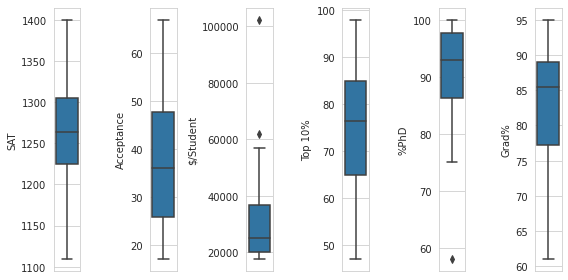

In [0]:
numeric_cols = ['SAT',	'Acceptance',	'$/Student',	'Top 10%',	'%PhD',	'Grad%']

plt.figure(figsize = (8, 4))
for i, col in enumerate(numeric_cols):
  plt.subplot(1, len(numeric_cols), i+1)
  ax = sns.boxplot(df[col], orient='v')
  # ax = sns.swarmplot(df[col], orient='v', color='.2')
  plt.tight_layout()

After drowing a boxplot we clearly see the outlier in '$/Student' row, as we supposed. We also found one more outlier in the same column and unexpectidly catched an outlier value in '%/PhD', which was missed before.

Let's also compare boxplots of different shool types.

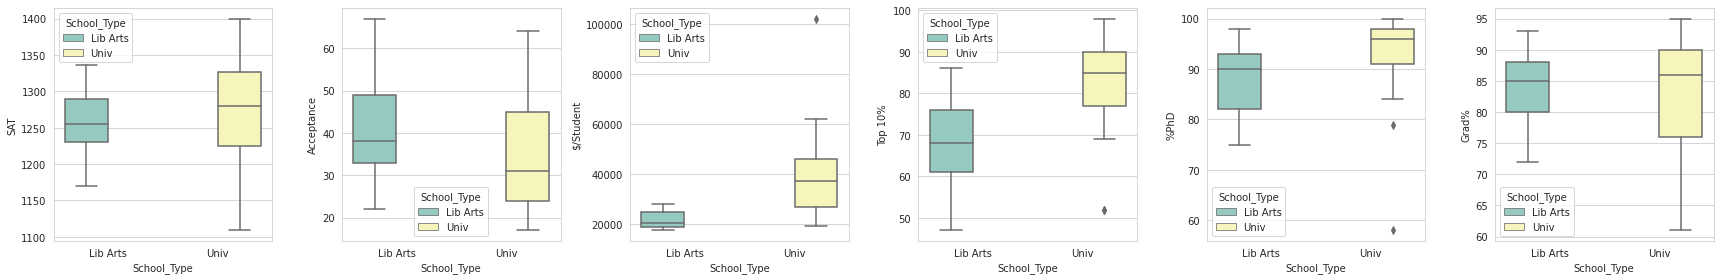

In [0]:
plt.figure(figsize = (24, 4))
for i, col in enumerate(numeric_cols):
  plt.subplot(1, len(numeric_cols), i+1)
  ax = sns.boxplot(x='School_Type', y=col, hue='School_Type', 
                   data=df[['School', 'School_Type', col]], 
                   orient='v', palette='Set3')
  plt.tight_layout()

Now we see the following differences:
1. SAT in universities has a wider distribution
2. Acceptance in 'Lib Arts' is a bit higher than in universities for all quartiles
3. The expenses per student in universities are much higher
4. Top10% are also in universities
5. Universities have larger amount of faculties with Phd programs
6. 'Lib Arts' has narrower distribution of % graduated. Medians are almost equal. Minimum graduated % is higher in 'Lib Arts'

Let's remove the outliers. To do so we'll use the '1.5 IQR' rule.

In [0]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
IQR = q3 - q1
print(IQR)

SAT              79.50
Acceptance       22.00
$/Student     16621.50
Top 10%          20.00
%PhD             11.50
Grad%            11.75
dtype: float64


To use 1.5 IQR rule we, firstly, need to multiply the interquartile range (IQR) by 1.5 (a constant used to discern outliers). 

$IQR = Q_{3} - Q_{1}$

We add 1.5 x (IQR) to the third quartile and substract same value from the first quartile. Any number greater or smaller than this is a suspected outlier.

In [0]:
df = df[~((df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))).any(axis=1)]
df.shape

(47, 8)

Let's count skewness and curtosis of our features.

In [0]:
skewness = []
kurtosis = []

for i, col in enumerate(numeric_cols):
  s = round(stats.skew(df[col]), 2)
  k = round(stats.kurtosis(df[col]), 2)
  skewness.append(s)
  kurtosis.append(k)

sk_df = pd.DataFrame([skewness, kurtosis], 
                     ['skewness', 'kurtosis'], 
                     numeric_cols)
sk_df.head()

,SAT,Acceptance,$/Student,Top 10%,%PhD,Grad%
skewness,-0.31,0.39,1.22,-0.28,-0.56,-0.75
kurtosis,-0.29,-0.85,0.60,-0.82,-0.74,0.04


Now we can look at destribution plots of our data without any outliers.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


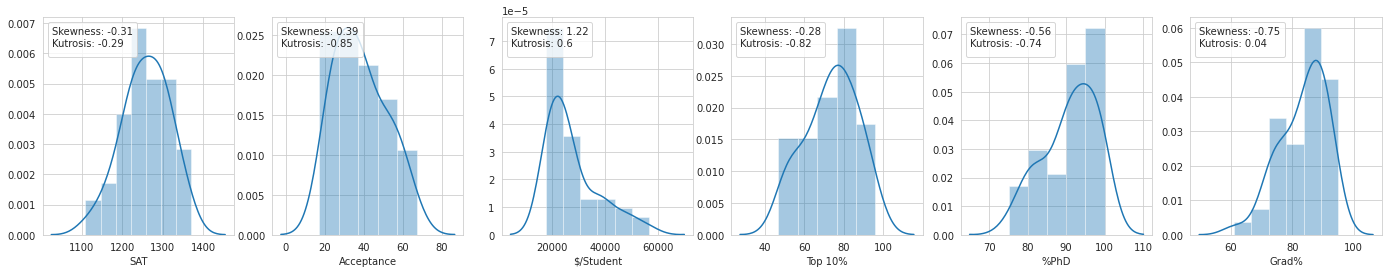

In [0]:
plt.figure(figsize=(24, 4))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, len(numeric_cols), i+1)
    sns.distplot(df[col], kde=True)
    sk_title = 'Skewness: ' + str(sk_df[[col]].iloc[0].values[0]) + '\nKutrosis: ' + str(sk_df[[col]].iloc[1].values[0])
    plt.legend(title=sk_title, loc='upper left')

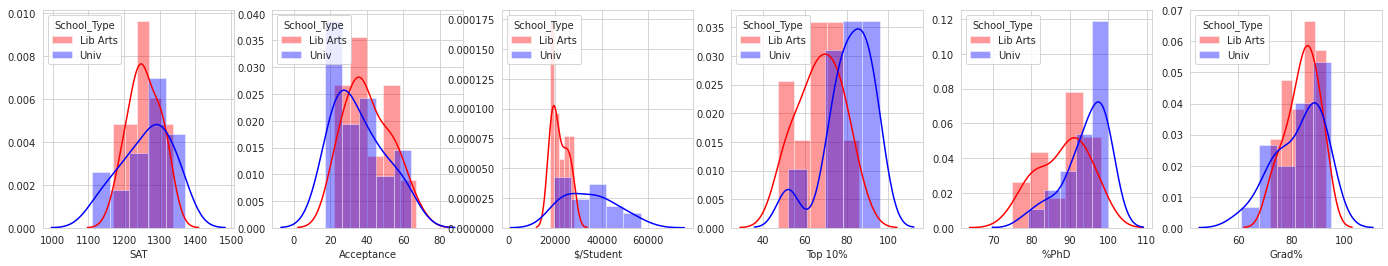

In [0]:
df_lib_arts = df[df['School_Type'] == 'Lib Arts']
df_univ = df[df['School_Type'] == 'Univ']

plt.figure(figsize=(24, 4))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, len(numeric_cols), i+1)

    sns.distplot(df_lib_arts[col], kde=True, color='red', bins=5)
    sns.distplot(df_univ[col], kde=True, color='blue', bins=5)
    plt.legend(title='School_Type', loc='upper left', labels=['Lib Arts', 'Univ'])

Comparind distribution plots we can add the following:
* 'Liv Arts' have higher kurtosis in 'SAT', '$/Student' and 'Grad%'
* Acceptance distribution is pretty close, but 'Lib Arts' has a bit higher
* '%PhD' has both higher skewness and kurtosis in universities

### Features correlation

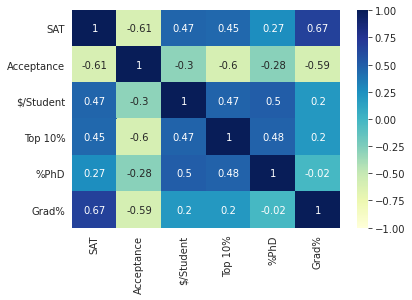

,SAT,Acceptance,$/Student,Top 10%,%PhD,Grad%
SAT,1.000000,-0.607610,0.468679,0.445580,0.265519,0.665040
Acceptance,-0.607610,1.000000,-0.302702,-0.600980,-0.283880,-0.590080
$/Student,0.468679,-0.302702,1.000000,0.471353,0.501437,0.202573
Top 10%,0.445580,-0.600980,0.471353,1.000000,0.481963,0.202456
%PhD,0.265519,-0.283880,0.501437,0.481963,1.000000,-0.020358
Grad%,0.665040,-0.590080,0.202573,0.202456,-0.020358,1.000000


In [0]:
sns.heatmap(df[numeric_cols].corr(), annot=True, vmin=-1, vmax=1, cmap="YlGnBu")
plt.show()
df[numeric_cols].corr()

There's no high-correlated (>80%) features in our data set, so we won't drop any of them.

## **Task 2: Стратификация**

*(обратите внимание на презентацию в материалах)*

Задача: 

Предположим, что генеральная совокупность - смесь 3х нормально распределенных с.в., и можем разбить ее на 3 страты. Доли страт в генеральной совокупности разные.

Необходимо сравнить свойства точечных оценок мат.ожидания и дисперсии, полученных на основе выборок с помощью:
1. Простого случайного выбора из всей генеральной совокупности 
2. Пропорционального разбиения на подсэмплы 
3. Оптимального разбиения на подсэмплы

Рассмотреть следующие случаи:

* A. Все страты имеют одинаковые мат. ожидания и дисперсии
* Б. Страты имеют разные мат.ожидания, но одинаковые дисперсии
* В. Страты имеют разные и мат. ожидания и дисперсии.

Объем объединенной выборки 40 и 500.
Проверка производится моделированием (1000 повторов).
Доли страт и параметры нормальных распределений выбираете самостоятельно.

1.	Стратификация должна быть написана самостоятельно. На основе формул.
2.	Стратификация должна быть применена ко всем трем случаям А,Б,В.
3.	Сделать вывод по полученным результатам.

### Stratification definition

Let's define the charachteristics of our initial data:

$L$ - number of subgroups in our sample

$n$ - volume of sample

$n_{k}$ - volume of $k$-th subgroup from our sample

$w_{k}$ - weight (% of sample) of $k$-th subgroup from our sample

In our task we have three groups: $k=3$. We'll take the relation of our three normally distributed random variables' weights as 3:2:1 $\Rightarrow w_{1}=0,5; w_{2}=0,335; w_{3}=0,165.$



In [0]:
weights = [0.5, 0.335, 0.165]

We'll also add functions for generating our samples. First is a function that generates random variable that consists of normally distributed variables from different strats with different weights.

In [0]:
def get_random_sample(size, weights, means, sigmas):
  """Function for generating a list of random normally distributed strats. Each of strats is a separate array.

  Args:
    size: Size of the sample.
    weights: List of the strats weights.
    means: List of the strats means.
    sigmas: List of the strats sigmas.

  Returns:
    List of ndarrays corresponding to each stratum.

  """
  strats_sizes = [round(w * size) for w in weights] # Random sampling with respect to weights

  sample = np.array([])
  for i in range(len(strats_sizes)):
    stratum = norm.rvs(size=strats_sizes[i], loc=means[i], scale=sigmas[i])
    sample = np.append(sample, stratum)

  return sample

The following function generates random normally distributed variables with proportional sizes to each sample: 

$n_{k} = n w_{k}$


In [0]:
def get_proportional_strats(size, weights, means, sigmas):
  """Function for generating a list of random normally distributed strats. Each of strats is a separate array.

  Args:
    size: Size of the sample.
    weights: List of the strats weights.
    means: List of the strats means.
    sigmas: List of the strats sigmas.

  Returns:
    List of ndarrays corresponding to each stratum.

  """
  strats_sizes = [round(w * size) for w in weights] # Proportional sampling

  strats = []
  for i in range(len(strats_sizes)):
    stratum = norm.rvs(size=strats_sizes[i], loc=means[i], scale=sigmas[i])
    strats.append(stratum)
  return strats


The following function generates random normally distributed variables with optimal sizes of each sample: 

$n_{k} = n \frac{w_{k} \sigma_{k}}{\sum_{k=1}^{L} w_{k} \sigma_{k}}$

In [0]:
def get_optimal_strats(size, weights, means, sigmas):
  """Function for generating a list of random normally distributed strats. Each of strats is a separate array. Size of each stratum is omptimized to minimize the variance.

  Args:
    size: Size of the sample.
    weights: List of the strats weights.
    means: List of the strats means.
    sigmas: List of the strats sigmas.

  Returns:
    List of ndarrays corresponding to each stratum with optimized stratum sizes.

  """

  weighted_sigmas_sum = 0
  for i in range(len(weights)):
    weighted_sigmas_sum += weights[i] * sigmas[i]

  # Optimal sampling
  strats_sizes = [] 
  for i in range(len(weights)):
    stratum_size = round(size * (weights[i] * sigmas[i]) / weighted_sigmas_sum)
    strats_sizes.append(stratum_size)

  strats = []
  for i in range(len(strats_sizes)):
    stratum = norm.rvs(size=strats_sizes[i], loc=means[i], scale=sigmas[i])
    strats.append(stratum)
  return strats


For measuring mean of mixture of sample subgroups we use the following formula:

$E = \sum_{k=1}^{L} w_{k} E_{k}$

For measuring the variance of mixture we use the following formula:

$\sigma^{2} = D = \sum_{k=1}^{L} w_{k} \left (\sigma_{k}^{2} + \left ( E_{k} - E \right )^{2} \right )$

The following function measures mean and variance of our samples. As it is said in the task, we need to make our measurement using three different approaches:
1. Make a simple random choice from our general population
2. Make a proportional choice accordingly to the weights of strats
3. Make an optimal choice

In [0]:
def get_general_mean(samples, weights):
  
  m = 0
  for i in range(len(weights)):
    m += weights[i] * samples[i].mean()
  return m

def get_general_std(samples, weights):

  general_mean = get_general_mean(samples, weights)
  var = 0
  for i in range(len(weights)):
    stratum_mean = samples[i].mean()
    stratum_std = samples[i].std()
    var += weights[i] * (stratum_std**2 + (stratum_mean - general_mean)**2)
  return var**(0.5)

def evaluate(size, weights, means, sigmas):

  simple_random_sample = get_random_sample(size, weights, means, sigmas)
  mean_1 = simple_random_sample.mean()
  std_1 = simple_random_sample.std()

  proportional_samples = get_proportional_strats(size, weights, means, sigmas)
  mean_2 = get_general_mean(proportional_samples, weights)
  std_2 = get_general_std(proportional_samples, weights)
  
  optimal_samples = get_optimal_strats(size, weights, means, sigmas)
  mean_3 = get_general_mean(optimal_samples, weights)
  std_3 = get_general_std(optimal_samples, weights)

  return np.array([mean_1, mean_2, mean_3, std_1, std_2, std_3])

The following function applies modeling according to needed sample size with custom repeats number.

In [0]:
def modeling(sample_size, repeats_number):

  evaluations = np.empty((0,6), int)

  for i in range(repeats_number):
    evaluation = evaluate(sample_size, weights, mean, sigma)
    evaluations = np.vstack((evaluations, evaluation))

  # Print table
  results = [['sample size: ' + str(sample_size), 'repeats number: ' + str(repeats_number)],
             ['simple mean', 'proportional mean', 'optimal mean', 'simple std', 'proportional std', 'optimal std'],
             list(evaluations.mean(axis=0))]
  print(tabulate(results, tablefmt='grid'))
 
  # Print boxplot
  lbl = ['0: simple', '1: proportional', '2: optimal']
  plt.figure(figsize = (10, 5))

  plt.subplot(1, 2, 1)
  ax = sns.boxplot(data=evaluations[:, :3], orient='v', palette='Set3')
  plt.legend(title='Mean', loc='upper left', labels=lbl)

  plt.subplot(1, 2, 2)
  ax = sns.boxplot(data=evaluations[:, 3:6], orient='v', palette='Set2')
  plt.legend(title='Std', loc='upper left', labels=lbl)


### Stratification applying

### Applying: case 1

Same mean and variance for all of our strats. Parameters for the normal distribution of variables:

$a_{1}=10, \sigma_{1}=5;$

$a_{2}=10, \sigma_{2}=5;$

$a_{3}=10, \sigma_{3}=5.$

In [0]:
mean = [10, 10, 10]
sigma = [5, 5, 5]

+--------------------+----------------------+------------------+-------------------+-------------------+------------------+
| sample size: 40    | repeats number: 1000 |                  |                   |                   |                  |
+--------------------+----------------------+------------------+-------------------+-------------------+------------------+
| simple mean        | proportional mean    | optimal mean     | simple std        | proportional std  | optimal std      |
+--------------------+----------------------+------------------+-------------------+-------------------+------------------+
| 10.036494494546325 | 10.010748762198842   | 9.99950633389505 | 4.892651750300785 | 4.917160613301992 | 4.89601340406349 |
+--------------------+----------------------+------------------+-------------------+-------------------+------------------+


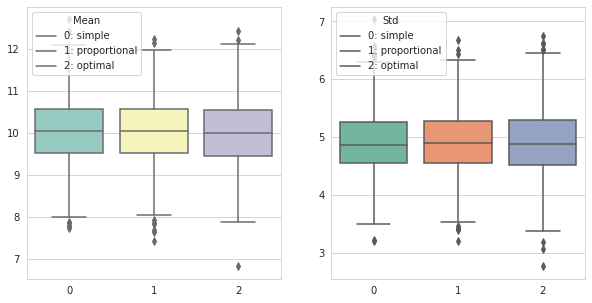

In [0]:
modeling(40, 1000)

+-------------------+----------------------+--------------------+-------------------+------------------+-------------------+
| sample size: 500  | repeats number: 1000 |                    |                   |                  |                   |
+-------------------+----------------------+--------------------+-------------------+------------------+-------------------+
| simple mean       | proportional mean    | optimal mean       | simple std        | proportional std | optimal std       |
+-------------------+----------------------+--------------------+-------------------+------------------+-------------------+
| 10.00130538732557 | 10.003455758754878   | 10.010331429993492 | 4.995070563877774 | 4.98573607628888 | 4.989208668093339 |
+-------------------+----------------------+--------------------+-------------------+------------------+-------------------+


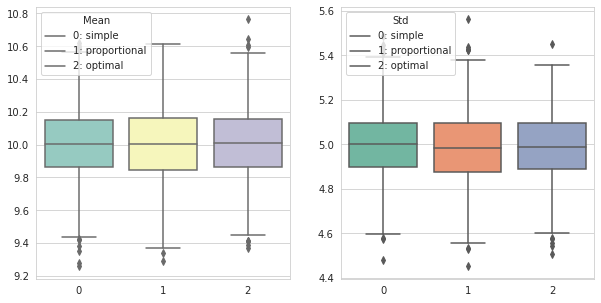

In [0]:
modeling(500, 1000)

### Applying: case 2

Strats have different means but same variances. Parameters for the normal distribution of variables:

$a_{1}=0, \sigma_{1}=5;$

$a_{2}=10, \sigma_{2}=5;$

$a_{3}=100, \sigma_{3}=5.$

In [0]:
mean = [0, 10, 100]
sigma = [5, 5, 5]

+------------------+----------------------+-------------------+-------------------+------------------+-------------------+
| sample size: 40  | repeats number: 1000 |                   |                   |                  |                   |
+------------------+----------------------+-------------------+-------------------+------------------+-------------------+
| simple mean      | proportional mean    | optimal mean      | simple std        | proportional std | optimal std       |
+------------------+----------------------+-------------------+-------------------+------------------+-------------------+
| 20.7320955034579 | 19.841823195634042   | 19.82979390711754 | 37.07819694009662 | 36.2306962603847 | 36.21735554489494 |
+------------------+----------------------+-------------------+-------------------+------------------+-------------------+


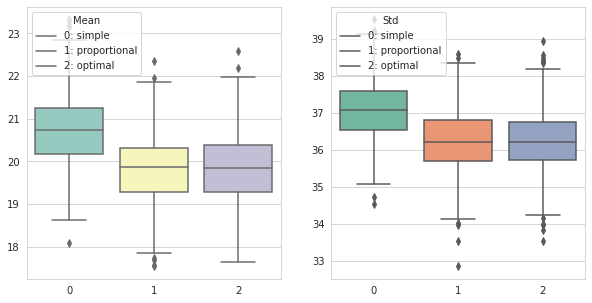

In [0]:
modeling(40, 1000)

+--------------------+----------------------+-------------------+--------------------+-------------------+--------------------+
| sample size: 500   | repeats number: 1000 |                   |                    |                   |                    |
+--------------------+----------------------+-------------------+--------------------+-------------------+--------------------+
| simple mean        | proportional mean    | optimal mean      | simple std         | proportional std  | optimal std        |
+--------------------+----------------------+-------------------+--------------------+-------------------+--------------------+
| 19.757092190046475 | 19.849674892741383   | 19.85517083736841 | 36.177593596984636 | 36.24946027805392 | 36.250507292698394 |
+--------------------+----------------------+-------------------+--------------------+-------------------+--------------------+


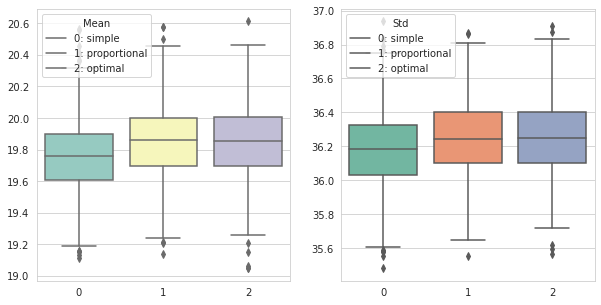

In [0]:
modeling(500, 1000)

### Applying: case 3

Both mean and variance are different for all of our strats. Parameters for the normal distribution of variables:

$a_{1}=0, \sigma_{1}=5;$

$a_{2}=10, \sigma_{2}=25;$

$a_{3}=100, \sigma_{3}=125.$

In [0]:
mean = [0, 10, 100]
sigma = [5, 25, 125]

+--------------------+----------------------+--------------------+-------------------+-------------------+-------------------+
| sample size: 40    | repeats number: 1000 |                    |                   |                   |                   |
+--------------------+----------------------+--------------------+-------------------+-------------------+-------------------+
| simple mean        | proportional mean    | optimal mean       | simple std        | proportional std  | optimal std       |
+--------------------+----------------------+--------------------+-------------------+-------------------+-------------------+
| 20.682162496137895 | 19.640196687772765   | 19.976012105966046 | 63.51742523510338 | 61.64148620764835 | 63.45616374136907 |
+--------------------+----------------------+--------------------+-------------------+-------------------+-------------------+


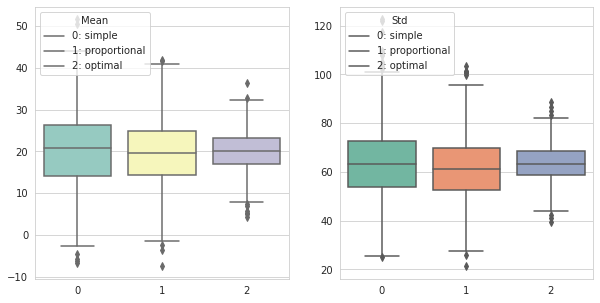

In [0]:
modeling(40, 1000)

+-------------------+----------------------+--------------------+------------------+-------------------+-------------------+
| sample size: 500  | repeats number: 1000 |                    |                  |                   |                   |
+-------------------+----------------------+--------------------+------------------+-------------------+-------------------+
| simple mean       | proportional mean    | optimal mean       | simple std       | proportional std  | optimal std       |
+-------------------+----------------------+--------------------+------------------+-------------------+-------------------+
| 19.68129177482052 | 19.81873160496623    | 19.815046739003822 | 63.4095108462288 | 63.75331775607107 | 63.83292652057459 |
+-------------------+----------------------+--------------------+------------------+-------------------+-------------------+


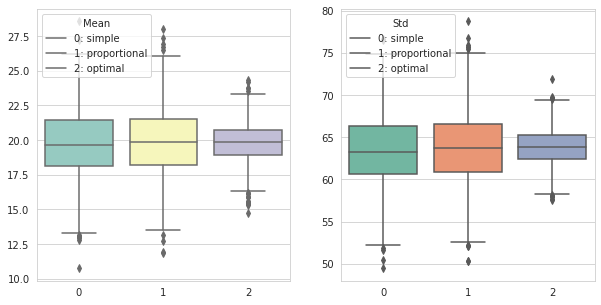

In [0]:
modeling(500, 1000)

### Summary

Let's say we have the following definitions:

$E_{s}, E_{p}, E_{o}$ - are mean values of simple, proportional and optimal sample.

$s_{s}, s_{p}, s_{o}$ - are appropriate standard deviations.

**Case 1:**

$a_{1} = a_{2} = a_{3}$

$\sigma_{1} = \sigma_{2} = \sigma_{3}$

Same mean and standard deviations' variances for all of our strats:

$Var(E_{s}) \approx Var(E_{p}) \approx Var(E_{o})$

$Var(s_{s}) \approx Var(s_{p}) \approx Var(s_{o})$

There's no significant difference in scatters of tested values. 

The only thing we have here is higher amount of outliers in case of random sampling.

**Case 2:**

$a_{1} < a_{2} < a_{3}$

$\sigma_{1} = \sigma_{2} = \sigma_{3}$

Strats have different variances of means but same of standard deviations:

$Var(E_{s}) \neq Var(E_{p}) \approx Var(E_{o})$

$Var(s_{s}) \approx Var(s_{p}) \approx Var(s_{o})$

Measurements made with simple random approach have higher dependency on number of values in sample.

**Case 3:**

$a_{1} < a_{2} < a_{3}$

$\sigma_{1} < \sigma_{2} < \sigma_{3}$

Both mean and standard deviation are more crowded $\Rightarrow$ have less variances:

$Var(E_{s}) \approx Var(E_{p}) > Var(E_{o})$

$Var(s_{s}) \approx Var(s_{p}) > Var(s_{o})$

In case of different standard diviations we have much less scatter of both mean and variance for the optimal sampling.

**General:**

Experiments with 500 values gave more accurate results than the experiments with 40 values: quartiles on first boxplot with 40 values in sample are about 5% distant from the median, while in case of 500 values quartiles are more than 3% closer to the median. For the standard deviation we also have more accurate results.

We can say that proportional sampling removes dependency on the size of sample.

The optimal sampling has valuable impact in case of different variances in subgroups of sample.

## **Task 3:	Проверка статистических гипотез**

Критерий SPRT  https://en.wikipedia.org/wiki/Sequential_probability_ratio_test, две простых гипотезы (средние берете из моделирования)

Задача: 

Создайте синтетические данные, полученные путем смешивания выборок из нормально распределеных генеральных совокупностей с разными параметрами. Применить к сгенерированным данным последовательный критерий Вальда силы (α′,β′), используя приближенные границы, для проверки гипотезы H0:a=a0 при альтернативе H1:a=a1 , считая σ0 известным. 

Какой объем выборок потребовался в каждом случае (следует проанализировать поведение критерия при разных долях компонент в смеси)? 

Выясните, не менее скольки наблюдений в среднем необходимо провести, если вы будете использовать последовательный критерий силы (α′,β′), в случае справедливости нулевой и альтернативной гипотез.

### SPRT definition

The hypotheses are:

$\left\{\begin{matrix}
 H_{0}:\theta=\theta_{0} \\ 
 H_{1}:\theta=\theta_{1}
\end{matrix}\right.$

$\theta_{1}>\theta_{0}$, where $a$ and $b$ depend on the desired type I and type II errors, $\alpha$ and $\beta$. 

They may be chosen as follows: $a\approx log\frac{\beta}{1 - \alpha}$ and $b\approx log\frac{1 - \beta}{\alpha}$

To calculate the cumulative sum of the log-likelihood ratio:

$S_{0}=0$; $S_{i}=S_{i-1}+log \Lambda_{i}$

The stopping rule is a simple thresholding scheme:

$a<S_{i}<b$ : continue monitoring (critical inequality)

$S_{i} \geqslant b$ : accept $H_{1}$

$S_{i} \leqslant a$ : accept $H_{0}$

The log-likelihood function (LLF) for one sample:

$log \Lambda (x) = - log \frac{\theta_{1}}{\theta_{0}} + \frac{\theta_{1}-\theta_{0}}{\theta_{0} \theta_{1}} x$

In [0]:
def get_random_weight_number(weights):
  randomizer = random.randrange(0, 1000, 1) / 1000
  accumulation = 0
  for i, w in enumerate(weights):
    accumulation += w
    if randomizer < accumulation:
      return i

def get_data_generator(weights, means, sigmas):
  size = 1000 # default size of generation to exclude infinite generation
  i = get_random_weight_number(weights)
  for j in range(size):
    yield norm.rvs(size=1, loc=means[i], scale=sigmas[i])


class SPRT_test_result_dto:

  def __init__(self):
    self.hypothesis_list = np.array([])
    self.s_list = np.array([])
    self.observations_list = np.array([])
  
  def add_result(self, h, s, observations):
    self.hypothesis_list = np.append(self.hypothesis_list, h)
    self.s_list = np.append(self.s_list, s)
    self.observations_list = np.append(self.observations_list, observations)

  def show_generalization(self):
    print("% of H0:a={} - {}".format(a0, (1 - self.hypothesis_list.mean())))
    print("% of H1:a={} - {}".format(a1, self.hypothesis_list.mean()))
    print("min observations number: " + str(self.observations_list.min()))
    print("max observations number: " + str(self.observations_list.max()))
    print("average observations number: " + str(self.observations_list.mean()))
    print("\n")


class SPRT:

  def __init__(self, alpha, beta):
    self.a = math.log(beta / (1 - alpha))
    self.b = math.log((1 - beta) / alpha)

  def test(self, teta0, teta1, tests_number):
    result = SPRT_test_result_dto()
    for t in range(tests_number):
      if t == 0:
        generator = get_data_generator(weights, mean, sigma)
        sns.distplot(list(generator), kde=False, label='data', color='teal', bins=20)
        plt.legend(prop={'size': 12});
      self._single_test(teta0, teta1, result)
    return result

  def _single_test(self, teta0, teta1, test_result_dto):
    h = None
    s = 0
    observations = 0
    generator = get_data_generator(weights, mean, sigma)

    for x in generator:
      s += self._get_likelihood_ratio(teta0, teta1, x.item(0))
      observations += 1
      if s <= self.a:
        h = 0
        break
      if s >= self.b:
        h = 1
        break
    
    if h != None:
      test_result_dto.add_result(h, s, observations)

  def _get_likelihood_ratio(self, teta0, teta1, x):
    return (- math.log(teta1 / teta0) + (teta1 - teta0) / (teta1 * teta0) * x)


In [0]:
alpha = 0.05
beta = 0.1
sprt = SPRT(alpha, beta)

a0 = 60
a1 = 50

weights = [0.5, 0.335, 0.165]
mean = [40, 50, 60]
sigma = [5, 10, 20]

### Analyze SPRT behavior 

* for sample size
* for observations number

% of H0:a=60 - 0.33999999999999997
% of H1:a=50 - 0.66
min observations number: 54.0
max observations number: 244.0
average observations number: 118.59




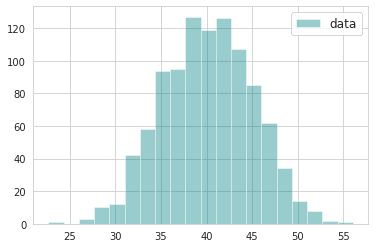

In [0]:
weights = [0.34, 0.33, 0.33]

test_result = sprt.test(a0, a1, 100)
test_result.show_generalization()

% of H0:a=60 - 0.17000000000000004
% of H1:a=50 - 0.83
min observations number: 53.0
max observations number: 272.0
average observations number: 110.77




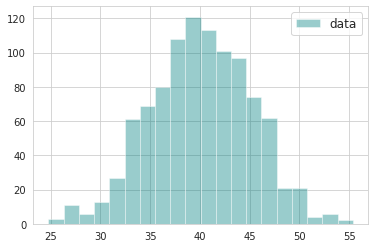

In [0]:
weights = [0.5, 0.335, 0.165]

test_result = sprt.test(a0, a1, 100)
test_result.show_generalization()

% of H0:a=60 - 0.040000000000000036
% of H1:a=50 - 0.96
min observations number: 52.0
max observations number: 221.0
average observations number: 88.62




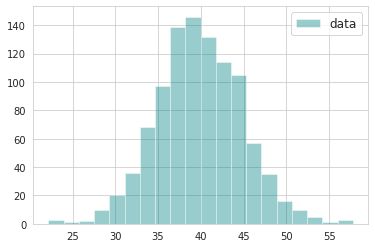

In [0]:
weights = [0.8, 0.15, 0.05]

test_result = sprt.test(a0, a1, 100)
test_result.show_generalization()

### Summary

We have the following results:
1. Predominance of one of subsamples increases the accuracy of the SPR tests
2. Predominance of one of subsamples decreases the volume of needed sample

## **Task 4: Корреляция**

Задача: 

1) Есть ли взаимосвязь между размером мозга интеллектом (следует применить критерий http://statistica.ru/theory/znachimost-koeffitsienta-korrelyatsii-doveritelnyy-interval/ для совместной выборки мужчин и женщин, а также для каждой из выборок в отдельности). Данные: https://kb.epam.com/download/attachments/570727359/brain.tsv?version=1&modificationDate=1539594861927&api=v2 

*Использовать критерий Фишера*

**Комментарий:** насколько я понимаю из ссылки на критерий, имелся в виду не F-тест, а Z-преобразование коэффициента корреляции

### Brain size & IQ correlation

Pearson correlation coefficient

In [0]:
df = pd.read_csv('/content/drive/My Drive/data/module_1/brain.tsv', sep='\t').drop(['Height', 'Weight'], axis=1)
df.head()

,Gender,FSIQ,VIQ,PIQ,MRI_Count
0,Female,133,132,124,816932
1,Male,140,150,124,1001121
2,Male,139,123,150,1038437
3,Male,133,129,128,965353
4,Female,137,132,134,951545


**Height, Weight** - irrelevant in this task

**FSIQ, VIQ, PIQ** - different IQ tests results

**MRI_Count** - size of brain on the photo

To apply pearson correlation test we need to check if the data is normally distributed. To check that we'll use the Shapiro-Wilk test:

$H_{0}$ - sample is normally distributed

$H_{1}$ - sample isn't normally distributed

We'll take $\alpha$ = 0.05

In [0]:
def test_normality(data):
  distribution_normality = dict()
  for column in data.drop('Gender', axis=1):
    print("{} p-value: {}, normally distributed: {}".format(column, stats.shapiro(data[column])[1], stats.shapiro(data[column])[1] >= 0.05))

df['Average_IQ'] = df[['FSIQ', 'VIQ', 'PIQ']].mean(axis=1)
test_normality(df)

FSIQ p-value: 3.057045250898227e-05, normally distributed: False
VIQ p-value: 0.00845432560890913, normally distributed: False
PIQ p-value: 0.013718176633119583, normally distributed: False
MRI_Count p-value: 0.3945104777812958, normally distributed: True
Average_IQ p-value: 8.265934593509883e-05, normally distributed: False


In [0]:
def test_correlation(data):
  for column in data.drop(['Gender', 'MRI_Count'], axis=1):
    correlation, p = stats.pearsonr(data['MRI_Count'], data[column])
    print('{} Pearson correlation: {}, p-value: {}'.format(column, correlation, p))
    # Fisher transform equals the inverse hyperbolic tangent
    # So, we'll use the transformation of the correlation coefficient into a Fishers' Z-score
    fishers_z_score = np.arctanh(correlation)
    print('{} Fishers\' Z-score: {}'.format(column, fishers_z_score))

test_correlation(df)

FSIQ Pearson correlation: 0.35764096936905665, p-value: 0.02346891262690166
FSIQ Fishers' Z-score: 0.37417825306898
VIQ Pearson correlation: 0.33747772802033543, p-value: 0.033201762692926864
VIQ Fishers' Z-score: 0.3512433256531444
PIQ Pearson correlation: 0.3868173150245029, p-value: 0.01367463603607323
PIQ Fishers' Z-score: 0.4080518949433215
Average_IQ Pearson correlation: 0.3744419970596907, p-value: 0.0172935918043347
Average_IQ Fishers' Z-score: 0.39357952564262993


**Summary - Total:**

Average_IQ correlation: 0.374

Average_IQ Fishers' Z-score: 0.394

### Male

FSIQ p-value: 0.0017663020407781005, normally distributed: False
VIQ p-value: 0.0191198717802763, normally distributed: False
PIQ p-value: 0.08110667765140533, normally distributed: True
MRI_Count p-value: 0.08370543271303177, normally distributed: True
Average_IQ p-value: 0.002564696129411459, normally distributed: False


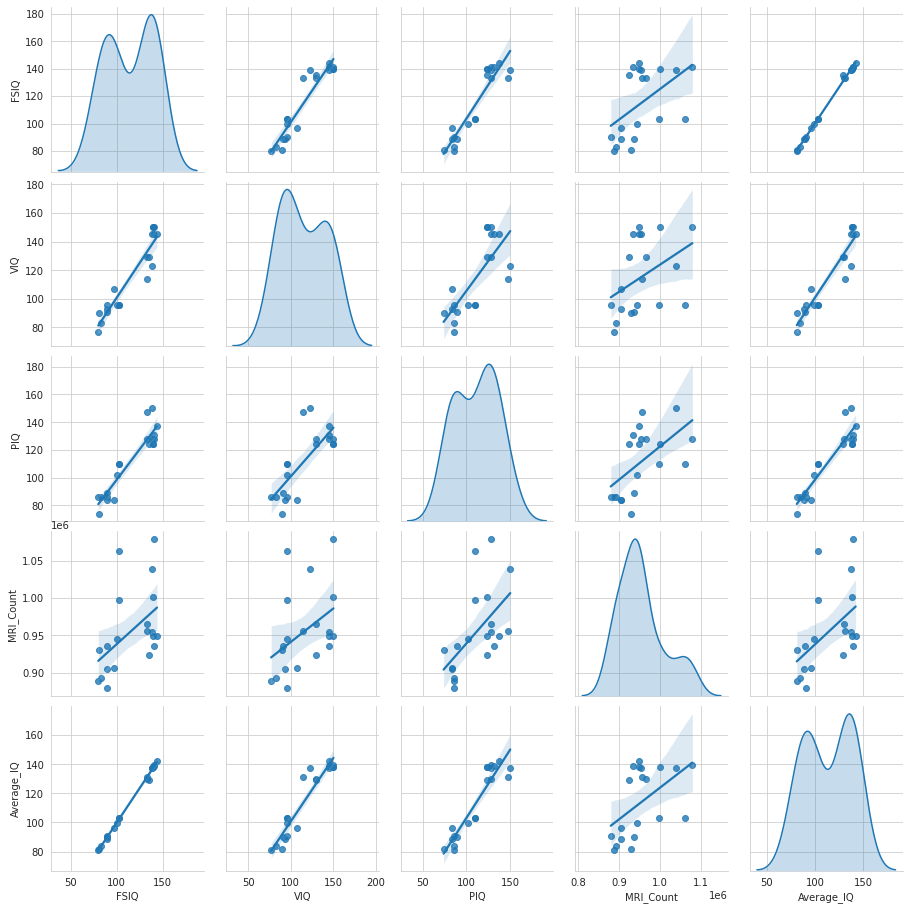

In [0]:
df_male = df.query('Gender == "Male"')
sns.pairplot(df_male, kind='reg', diag_kind='kde')
test_normality(df_male)

In [0]:
test_correlation(df_male)

FSIQ Pearson correlation: 0.49836911041719256, p-value: 0.025319401349742674
FSIQ Fishers' Z-score: 0.5471339831736516
VIQ Pearson correlation: 0.4131049601428286, p-value: 0.0702406382764465
VIQ Fishers' Z-score: 0.43934933279801713
PIQ Pearson correlation: 0.5682370032144156, p-value: 0.008949874911640737
PIQ Fishers' Z-score: 0.6449152601757674
Average_IQ Pearson correlation: 0.5117288000718087, p-value: 0.021087749214196667
Average_IQ Fishers' Z-score: 0.5650690932868934


**Summary - Male:**

Average_IQ correlation: 0.512

Average_IQ Fishers' Z-score: 0.565

### Female

FSIQ p-value: 0.001717039500363171, normally distributed: False
VIQ p-value: 0.006750611122697592, normally distributed: False
PIQ p-value: 0.2030726671218872, normally distributed: True
MRI_Count p-value: 0.12257107347249985, normally distributed: True
Average_IQ p-value: 0.0024386350996792316, normally distributed: False


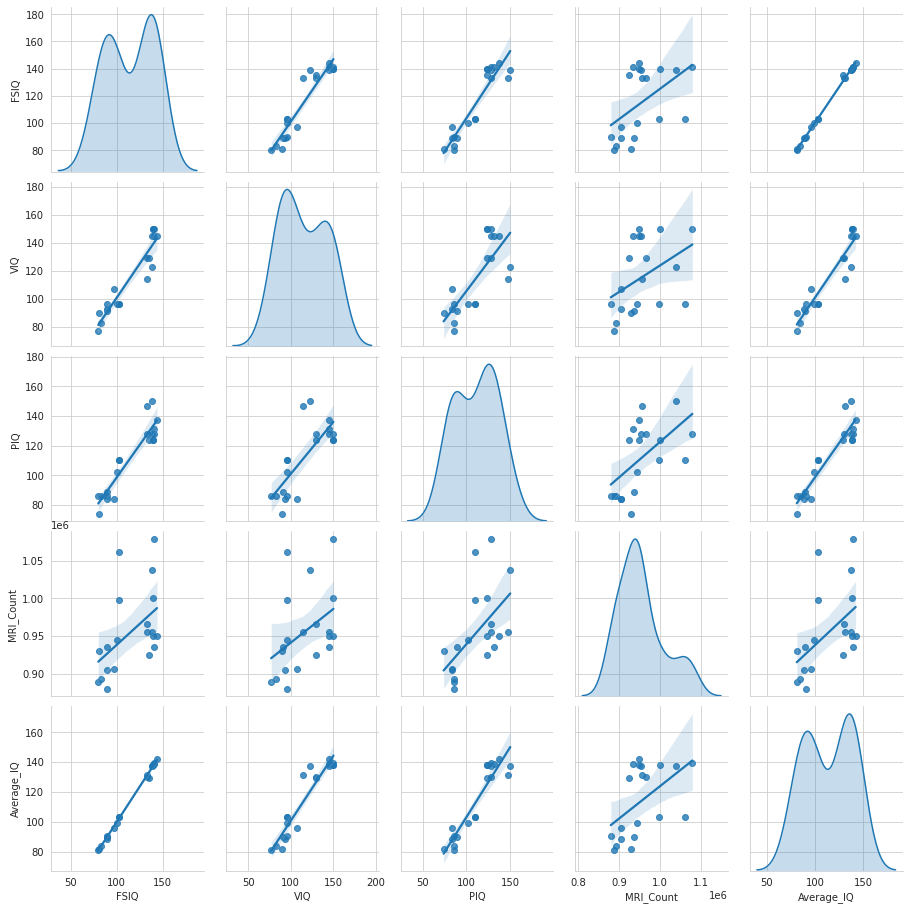

In [0]:
df_female = df.query('Gender == "Female"')
sns.pairplot(df_male, kind='reg', diag_kind='kde')
test_normality(df_female)

In [0]:
test_correlation(df_female)

FSIQ Pearson correlation: 0.3256967004963704, p-value: 0.1611157761890763
FSIQ Fishers' Z-score: 0.33800670148430895
VIQ Pearson correlation: 0.2549328529614766, p-value: 0.27803963279018523
VIQ Fishers' Z-score: 0.2606815009735188
PIQ Pearson correlation: 0.39615716686847646, p-value: 0.08378071936817734
PIQ Fishers' Z-score: 0.41908245333738015
Average_IQ Pearson correlation: 0.33709457721383546, p-value: 0.14611157442578976
Average_IQ Fishers' Z-score: 0.35081099168377455


**Female:**

Average_IQ correlation: 0.337

Average_IQ Fishers' Z-score: 0.351

*According to correlation values, for men interrelation between brain size and IQ test results is slightly higher than for women. Taking into account p-value of Pearson correltion test results allows us to say, that there's no correlation between brain size and IQ test results for women.*

### Car preferences

Задача: 

2) Есть ли различия в выборе авто между мужчинами и женщинами (здесь следует применить http://www.machinelearning.ru/wiki/index.php?title=%D0%A2%D0%B0%D0%B1%D0%BB%D0%B8%D1%86%D0%B0_%D1%81%D0%BE%D0%BF%D1%80%D1%8F%D0%B6%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8). 

Данные : https://kb.epam.com/download/attachments/570727359/carprefs.tsv?version=1&modificationDate=1539594893979&api=v2 

*Использовать критерий Хи-квадрат*

In [0]:
df = pd.read_csv('/content/drive/My Drive/data/module_1/carprefs.tsv', sep='\t')
df.head()

,ID,Age,Sex,LicYr,LicMth,ActCar,Kids5,Kids6,PreferCar,Car15K,Reason,Cost,Reliable,Perform,Fuel,Safety,AC/PS,Park,Room,Doors,Prestige,Colour
0,110,18,2,0,2,3,2,2,2,2,1,3,4,3,3,3,3,3,3,3,3,2
1,111,25,1,8,0,1,2,2,1,1,1,4,4,4,4,4,3,4,4,2,3,3
2,112,63,2,46,0,3,2,2,3,2,5,3,3,3,3,3,3,3,3,3,3,3
3,113,51,1,35,0,3,2,2,2,2,1,2,3,3,3,4,3,3,3,3,1,3
4,114,19,1,2,0,2,2,2,2,1,6,3,3,4,3,3,2,3,3,2,3,3


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 22 columns):
ID           300 non-null int64
Age          300 non-null int64
Sex          300 non-null int64
LicYr        300 non-null int64
LicMth       300 non-null int64
ActCar       300 non-null int64
Kids5        300 non-null int64
Kids6        300 non-null int64
PreferCar    300 non-null int64
Car15K       300 non-null int64
Reason       300 non-null int64
Cost         300 non-null int64
Reliable     300 non-null int64
Perform      300 non-null int64
Fuel         300 non-null int64
Safety       300 non-null int64
AC/PS        300 non-null int64
Park         300 non-null int64
Room         300 non-null int64
Doors        300 non-null int64
Prestige     300 non-null int64
Colour       300 non-null int64
dtypes: int64(22)
memory usage: 51.7 KB


We'll use only 'PreferCar' feature as it can be clearly described as buyers' choice preferences.

Also, we'll assume the following distribution about gender:

1 - male

2 - female

In [0]:
df = df[['Sex', 'PreferCar']]
df.head()

,Sex,PreferCar
0,2,2
1,1,1
2,2,3
3,1,2
4,1,2


Constructing a contingency table

In [0]:
grouped_size = df.groupby(['Sex', 'PreferCar'], as_index=False).size()
table = grouped_size.values.reshape(df.Sex.nunique(), df.PreferCar.nunique())
grouped_size

Sex  PreferCar
1    1            43
     2            75
     3            26
     4             6
2    1            25
     2            61
     3            47
     4            17
dtype: int64

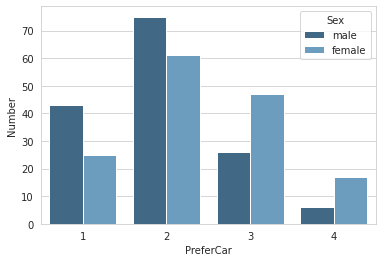

In [0]:
sex_prefercar_df = pd.DataFrame(grouped_size).reset_index().rename({0: 'Number'}, axis=1)
sex_prefercar_df.Sex.replace({1: 'male', 2: 'female'}, inplace=True)
sns.barplot(data=sex_prefercar_df, hue='Sex', x='PreferCar', y='Number', palette="Blues_d");

Let's apply Chi-squeared method to find out if there's a statistically significant difference in preferences of men and women:

$H_0$ - there's no statistically significant difference between distributions of populations

$H_1$ - there's statistically significant difference between distributions of populations

In [0]:
result = stats.chi2_contingency(table)
print('p-value: {}'.format(result[1]))

p-value: 0.0005555699275518034


**Symmary**

Since p-value is less than 0.05 we reject H0 and assume that there's a statistically significant difference.